# Transformers (Parte 2): Multi-Head Attention, Máscara Causal, Positional Encoding e Blocos

**Nesta aula você vai:**
- Compreender a **Multi-Head Attention (MHA)** e implementá-la (projeções Q/K/V por cabeça, concatenação e Wᵒ).
- Entender e construir a **máscara causal** usada na self-attention do **decoder**.
- Implementar o **Positional Encoding senoidal** e somá-lo aos embeddings.
- Montar um **EncoderLayer** e um **DecoderLayer** (com Add&Norm, Dropout e FFN).
- Executar um **forward de referência** (encoder→decoder) e visualizar **pesos de atenção por cabeça**.

> Referência: Seções 3.1 (pilhas encoder/decoder), 3.2 (attention & multi-head), 3.3 (FFN), 3.5 (positional encoding) do *Attention Is All You Need*.

## Relembrando...

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/transformers_architecture.png" width="50%%">

Fonte: Paper Attention is all you need (Wasani et al., 2017)

## 1) Intuição: por que várias cabeças?

Uma única atenção (uma cabeça) já consegue misturar contexto global. Mas, ao **promediar** as contribuições, ela pode “diluir” padrões distintos. A **Multi-Head Attention (MHA)** resolve isso ao:
- Projetar Q, K e V em **subespaços** menores (uma projeção **por cabeça**),
- Fazer atenção **em paralelo** nessas projeções,
- **Concatenar** as saídas das cabeças,
- E aplicar uma projeção final **Wᵒ** de volta a `d_model`.

**Efeito prático:** cada cabeça aprende um “olhar” diferente (sintaxe, concordância, alinhamento léxico, dependências longas etc.), e a concatenação reúne esses “subpadrões” em uma representação única mais rica.  
(h=8, com `d_k = d_v = d_model / h` no modelo base).  

In [ ]:
# Multi-Head Attention 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8, dropout=0.1, bias=True, return_attn_weights=True):
        """
        Construtor de um módulo de Atenção Multi-Cabeças (Multi-Head Attention).

        Parâmetros:
            d_model (int): Dimensão total do vetor de entrada e saída do modelo (ex: 512).
            num_heads (int): Número de "cabeças" de atenção independentes.
            dropout (float): Taxa de dropout aplicada após a combinação das cabeças.
            bias (bool): Indica se as camadas lineares devem usar termo de viés.
            return_attn_weights (bool): Se True, retorna também os pesos de atenção.
        """

        # Chamada ao construtor da classe base nn.Module (necessário em todos módulos PyTorch customizados)
        super().__init__()

        # Verifica se d_model é divisível pelo número de cabeças — requisito da arquitetura.
        # Cada cabeça recebe uma fração do vetor total, logo deve haver divisão exata.
        assert d_model % num_heads == 0, "d_model deve ser múltiplo de num_heads"

        # Armazena atributos principais do módulo
        self.d_model = d_model       # dimensão total dos vetores de entrada/saída
        self.h = num_heads           # número de cabeças de atenção
        self.d_k = d_model // num_heads  # dimensão do subvetor 'chave' por cabeça
        self.d_v = d_model // num_heads  # dimensão do subvetor 'valor' por cabeça
        self.return_attn_weights = return_attn_weights  # controla se os pesos serão retornados

        # ----------------------------------------------------------
        # Projeções lineares para gerar Q (queries), K (keys) e V (values)
        # ----------------------------------------------------------
        # Cada uma é uma camada linear que mapeia do espaço de entrada (d_model)
        # para o mesmo espaço, antes de dividir entre as cabeças.
        # Essas projeções permitem que o modelo aprenda diferentes transformações
        # do mesmo vetor de entrada, de modo que cada cabeça possa "atender"
        # a diferentes aspectos das representações.
        self.W_Q = nn.Linear(d_model, d_model, bias=bias)
        self.W_K = nn.Linear(d_model, d_model, bias=bias)
        self.W_V = nn.Linear(d_model, d_model, bias=bias)

        # ----------------------------------------------------------
        # Projeção de saída (W^O)
        # ----------------------------------------------------------
        # Depois que todas as cabeças processam suas atenções individualmente,
        # seus resultados são concatenados e passam por esta projeção linear
        # para retornar ao espaço de dimensão d_model.
        self.W_O = nn.Linear(d_model, d_model, bias=bias)

        # Dropout aplicado após a combinação das cabeças,
        # ajuda a evitar overfitting e estabiliza o treinamento.
        self.dropout = nn.Dropout(dropout)

    def _split_heads(self, x):
        """
        Divide o tensor de entrada em múltiplas cabeças de atenção.

        Parâmetros:
            x (Tensor): Tensor de entrada com forma (B, seq, d_model)
                        onde:
                            B   = tamanho do batch
                            seq = comprimento da sequência (número de tokens)
                            d_model = dimensão total do modelo

        Retorna:
            Tensor com forma (B, h, seq, d_k), onde:
                h   = número de cabeças de atenção
                d_k = dimensão da sub-representação de cada cabeça (d_model / h)
        """

        # Extrai o tamanho do batch (B) e o comprimento da sequência (T = seq length)
        B, T, _ = x.shape

        # --------------------------------------------------------------
        # 1) Rearranjo das dimensões
        # --------------------------------------------------------------
        # O tensor original tem forma (B, seq, d_model)
        # Queremos reorganizá-lo para separar as 'h' cabeças.
        # Como cada cabeça trabalha com um subespaço de dimensão d_k,
        # dividimos o último eixo (d_model) em (h, d_k).
        #
        # Resultado intermediário: (B, seq, h, d_k)
        x = x.view(B, T, self.h, self.d_k)

        # --------------------------------------------------------------
        # 2) Transposição de eixos
        # --------------------------------------------------------------
        # Trocamos a posição de 'seq' e 'h' para facilitar os cálculos
        # posteriores de atenção, que esperam o formato (B, h, seq, d_k).
        #
        # - Antes: (B, seq, h, d_k)
        # - Depois: (B, h, seq, d_k)
        #
        # Isso permite que cada cabeça opere de forma independente
        # sobre a dimensão da sequência.
        x = x.transpose(1, 2)

        # Retorna o tensor reorganizado com as cabeças separadas
        return x

    def _combine_heads(self, x):
        """
        Combina novamente as múltiplas cabeças de atenção em um único tensor.

        Parâmetros:
            x (Tensor): Tensor com forma (B, h, seq, d_v)
                        onde:
                            B   = tamanho do batch
                            h   = número de cabeças
                            seq = comprimento da sequência (número de tokens)
                            d_v = dimensão do vetor de valor por cabeça

        Retorna:
            Tensor com forma (B, seq, h * d_v),
            que corresponde à dimensão total do modelo (d_model).
        """

        # Extrai dimensões do tensor de entrada
        B, h, T, dv = x.shape

        # --------------------------------------------------------------
        # 1) Transposição de eixos
        # --------------------------------------------------------------
        # O formato atual é (B, h, seq, d_v).
        # Queremos trazer 'seq' para a segunda posição, de modo que
        # a sequência volte a ser o segundo eixo (como era no início).
        #
        # Resultado intermediário: (B, seq, h, d_v)
        x = x.transpose(1, 2)

        # --------------------------------------------------------------
        # 2) "contiguous()" e "view()" para reformatar o tensor
        # --------------------------------------------------------------
        # O método .contiguous() garante que os dados na memória estejam
        # organizados de forma contínua após a transposição.
        #
        # Em seguida, usamos .view() para "achatar" as dimensões
        # (h, d_v) em uma só, voltando ao tamanho total do modelo.
        #
        # Resultado final: (B, seq, h * d_v)
        # Esse h * d_v é, por construção, igual a d_model.
        x = x.contiguous().view(B, T, h * dv)

        # Retorna o tensor combinado, pronto para a projeção final W_O
        return x

    def forward(self, Q_in, K_in, V_in, attn_mask=None):
        """
        Executa a Atenção Multi-Cabeças (MHA) no par (consulta, chave, valor).

        Parâmetros:
            Q_in (Tensor): Tensores de "queries" com forma (B, seq_q, d_model).
            K_in (Tensor): Tensores de "keys"    com forma (B, seq_k, d_model).
            V_in (Tensor): Tensores de "values"  com forma (B, seq_k, d_model).
            attn_mask (Tensor | None): Máscara booleana/0-1 para restringir atenção.
                Formas aceitas:
                - (B, 1,  seq_q, seq_k): mesma máscara para todas as cabeças
                - (B, h,  seq_q, seq_k): máscara específica por cabeça
                Convenção: 1 = permitido, 0 = proibido.

        Retorna:
            out (Tensor): Saída projetada, forma (B, seq_q, d_model).
            attn (Tensor, opcional): Pesos de atenção por cabeça (B, h, seq_q, seq_k),
                                    retornado apenas se self.return_attn_weights == True.
        """

        # ----------------------------
        # 0) Verificações de consistência
        # ----------------------------
        B, Tq, _ = Q_in.shape             # B = batch size, Tq = len da sequência de queries
        Bk, Tk, _ = K_in.shape            # Tk = len da sequência de keys/values
        assert B == Bk, "batch size precisa bater"

        # ----------------------------
        # 1) Projeções lineares iniciais
        # ----------------------------
        # Transformam Q/K/V para subespaços aprendidos antes de dividir em cabeças.
        # Mantêm dimensão d_model para que possamos fatiar em h cabeças de tamanho d_k/d_v.
        Q = self.W_Q(Q_in)  # (B, Tq, d_model)
        K = self.W_K(K_in)  # (B, Tk, d_model)
        V = self.W_V(V_in)  # (B, Tk, d_model)

        # ----------------------------
        # 2) Separar em cabeças
        # ----------------------------
        # De (B, seq, d_model) para (B, h, seq, d_k/d_v)
        Q = self._split_heads(Q)  # (B, h, Tq, d_k)
        K = self._split_heads(K)  # (B, h, Tk, d_k)
        V = self._split_heads(V)  # (B, h, Tk, d_v)

        # ----------------------------
        # 3) Atenção Escalonada (Scaled Dot-Product Attention)
        # ----------------------------
        # scores = Q · K^T / sqrt(d_k)
        #   - Similaridade entre cada posição de Q e todas as posições de K.
        #   - A normalização por sqrt(d_k) estabiliza gradientes para d_k grandes.
        # Resultado: (B, h, Tq, Tk)
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.d_k)

        # ----------------------------
        # 4) Aplicar máscara (opcional)
        # ----------------------------
        # Máscara típica:
        #   - Causal (triangular) para impedir olhar o futuro no decodificador.
        #   - Padding mask para ignorar tokens de preenchimento.
        # Conveção: 0 = posição proibida -> definimos score = -inf (zera no softmax).
        if attn_mask is not None:
            # Broadcasting automático para (B, h, Tq, Tk) se vier (B, 1, Tq, Tk)
            scores = scores.masked_fill(attn_mask == 0, float("-inf"))

        # ----------------------------
        # 5) Softmax sobre a dimensão das chaves (última)
        # ----------------------------
        # Converte scores em distribuição de probabilidade por cabeça.
        attn = F.softmax(scores, dim=-1)   # (B, h, Tq, Tk)
        attn = self.dropout(attn)          # regularização (após softmax é comum em MHA)

        # ----------------------------
        # 6) Combinar pesos com V
        # ----------------------------
        # Multiplica a distribuição de atenção pelos valores.
        # Saída por cabeça: (B, h, Tq, d_v)
        heads_out = torch.matmul(attn, V)

        # ----------------------------
        # 7) Concatenar cabeças e projetar
        # ----------------------------
        # (B, h, Tq, d_v) -> (B, Tq, h*d_v=d_model)
        concat = self._combine_heads(heads_out)  # (B, Tq, d_model)
        out = self.W_O(concat)                   # projeção final para d_model

        # ----------------------------
        # 8) Retorno (com ou sem pesos)
        # ----------------------------
        if self.return_attn_weights:
            # Útil para inspeção/visualização didática e para diagnósticos
            return out, attn
        return out

## 2) Máscara causal (decoder)

Na **self-attention do decoder**, queremos impedir que a posição *i* olhe para posições *j > i* (o “futuro”).  
Isso garante a propriedade **auto-regressiva**: prever o próximo token usando apenas o que já foi gerado.

**Como implementamos:**
- Criamos uma matriz triangular inferior (1s no triângulo inferior, 0s acima da diagonal).
- Opcionalmente combinamos com uma **padding mask** (para tokens `<pad>`).

No forward da atenção, **scores** recebem `-inf` onde a máscara é 0, antes do softmax.

In [ ]:
import torch

def causal_mask(seq_len, device=None):
    """
    Gera uma máscara de atenção causal (triangular inferior),
    usada principalmente em modelos autoregressivos (como o decodificador de Transformers),
    para impedir que um token "veja" posições futuras.

    Parâmetros:
        seq_len (int): Tamanho da sequência (número de tokens).
        device (torch.device | None): Dispositivo no qual a máscara será criada (CPU/GPU).

    Retorna:
        Tensor com forma (1, 1, seq_len, seq_len), onde:
            - Valor 1 indica posição permitida (j <= i)
            - Valor 0 indica posição proibida (j > i)
    """
    # --------------------------------------------------------------
    # torch.ones(seq_len, seq_len): cria uma matriz cheia de 1s
    # torch.tril(...): mantém apenas a parte triangular inferior (inclusive diagonal)
    # dtype=torch.uint8: máscara binária (1/0)
    # device=device: garante que a máscara esteja no mesmo dispositivo que os tensores
    # --------------------------------------------------------------
    m = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.uint8, device=device))

    # --------------------------------------------------------------
    # A máscara é reshapeada para ter as dimensões esperadas:
    # (1, 1, seq, seq)
    #   - 1ª dimensão: batch fictício (para broadcasting)
    #   - 2ª dimensão: cabeças de atenção (será broadcast em h)
    #   - 3ª e 4ª: posições de query e key
    # --------------------------------------------------------------
    return m.view(1, 1, seq_len, seq_len)

def padding_mask(pad_ids, pad_token_id=0):
    """
    Gera uma máscara para ignorar posições de *padding* em uma sequência.

    Parâmetros:
        pad_ids (Tensor): Tensor de tokens com forma (B, seq),
                          onde cada posição contém o ID do token.
        pad_token_id (int): ID usado para o token <pad> (0 por padrão).

    Retorna:
        Tensor com forma (B, 1, 1, seq), onde:
            - Valor 1 indica posição válida (token real)
            - Valor 0 indica posição de padding (deve ser ignorada)
    """

    # --------------------------------------------------------------
    # Cria um tensor booleano indicando quais posições NÃO são pad.
    # (pad_ids != pad_token_id) → True onde é token real.
    # As dimensões extras são adicionadas com unsqueeze() para compatibilidade
    # com a atenção: (B, 1, 1, seq).
    # --------------------------------------------------------------
    not_pad = (pad_ids != pad_token_id).unsqueeze(1).unsqueeze(2)

    # --------------------------------------------------------------
    # Converte para uint8 (0/1) para manter compatibilidade
    # com operações de máscara em PyTorch.
    # --------------------------------------------------------------
    return not_pad.to(torch.uint8)

In [3]:
print("Máscara causal (seq_len=5):")
print(causal_mask(5))

pad_ids = torch.tensor([[1, 2, 3, 0, 0],
                        [4, 5, 0, 0, 0],
                        [6, 7, 8, 9,10]])
print("\nMáscara de padding (pad_token_id=0):")
print(padding_mask(pad_ids, pad_token_id=0))

Máscara causal (seq_len=5):
tensor([[[[1, 0, 0, 0, 0],
          [1, 1, 0, 0, 0],
          [1, 1, 1, 0, 0],
          [1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1]]]], dtype=torch.uint8)

Máscara de padding (pad_token_id=0):
tensor([[[[1, 1, 1, 0, 0]]],


        [[[1, 1, 0, 0, 0]]],


        [[[1, 1, 1, 1, 1]]]], dtype=torch.uint8)


## 3) Positional Encoding (PE) senoidal

Como o Transformer **não** usa recorrência nem convolução, ele precisa injetar **informação de ordem**.  
O *Positional Encoding* (PE) senoidal é somado aos embeddings:

Para a posição `pos` (0-index) e dimensão `i`:

$$
PE_{pos, 2i} = \sin\!\left(\frac{pos}{10000^{2i/d_{model}}}\right), \quad
PE_{pos, 2i+1} = \cos\!\left(\frac{pos}{10000^{2i/d_{model}}}\right).
$$

**Intuição prática:**
- Permite que o modelo **diferencie posições** e reconheça **padrões relativos** (diferenças de fase/frequência).
- As frequências variam ao longo das dimensões; isso ajuda a codificar distâncias relativas.  

In [ ]:
import math
import torch
import torch.nn as nn

class SinusoidalPositionalEncoding(nn.Module):
    """
    Implementa a codificação posicional senoidal proposta no artigo
    "Attention is All You Need" (Vaswani et al., 2017).

    Objetivo:
        Fornecer ao modelo informações sobre a posição dos tokens
        na sequência, já que a arquitetura Transformer não possui
        nenhuma noção sequencial embutida (ela é totalmente paralela).

    Cada posição i é associada a um vetor PE[i], cujos valores
    seguem padrões de seno e cosseno de diferentes frequências.
    Isso cria uma codificação contínua e determinística.
    """

    def __init__(self, d_model, max_len=5000, device=None):
        """
        Parâmetros:
            d_model (int): Dimensão dos embeddings (mesma usada pelo modelo).
            max_len (int): Tamanho máximo de sequência para pré-computar PE.
            device (torch.device | None): Dispositivo onde o tensor será criado.
        """
        super().__init__()
        self.d_model = d_model

        # --------------------------------------------------------------
        # 1) Inicialização da matriz de codificação posicional
        # --------------------------------------------------------------
        # Cria uma matriz 'pe' de zeros com forma (max_len, d_model)
        # onde cada linha corresponde a uma posição (0, 1, 2, ..., max_len-1)
        # e cada coluna corresponde a uma dimensão do embedding.
        pe = torch.zeros(max_len, d_model, device=device)

        # Vetor de posições: [0, 1, 2, ..., max_len-1]
        # unsqueeze(1) => forma (max_len, 1)
        pos = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)

        # --------------------------------------------------------------
        # 2) Cálculo dos divisores de frequência
        # --------------------------------------------------------------
        # A cada duas dimensões (pares e ímpares), usamos uma frequência diferente.
        # Fórmula (do paper):
        #   PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
        #   PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        # Abaixo, 'div' contém os termos 1 / 10000^(2i/d_model)
        div = torch.exp(
            torch.arange(0, d_model, 2, device=device).float() * (-math.log(10000.0) / d_model)
        )

        # --------------------------------------------------------------
        # 3) Preenchimento alternado com seno e cosseno
        # --------------------------------------------------------------
        # Dimensões pares (0, 2, 4, ...): seno
        # Dimensões ímpares (1, 3, 5, ...): cosseno
        # pos * div realiza o broadcast para todas as posições e frequências
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)

        # --------------------------------------------------------------
        # 4) Ajuste de formato para compatibilidade com o batch
        # --------------------------------------------------------------
        # Adiciona uma dimensão extra no início:
        # (1, max_len, d_model)
        # → permite somar diretamente com o embedding (B, seq, d_model)
        pe = pe.unsqueeze(0)

        # --------------------------------------------------------------
        # 5) Registro da codificação como buffer
        # --------------------------------------------------------------
        # 'register_buffer' armazena o tensor como parte do módulo,
        # mas sem ser um parâmetro treinável (não aparece no otimizador).
        # persistent=False → não será salvo no state_dict (pois é determinístico).
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        """
        Aplica a codificação posicional ao embedding de entrada.

        Parâmetros:
            x (Tensor): Embeddings de entrada, forma (B, seq, d_model).

        Retorna:
            Tensor da mesma forma, com codificação posicional somada:
                (B, seq, d_model)
        """
        seq_len = x.size(1)  # comprimento real da sequência
        # Soma o embedding à fatia correspondente da codificação posicional
        return x + self.pe[:, :seq_len, :]

torch.Size([2, 6, 512])
tensor([[[-1.6738,  1.1457, -1.0376,  ...,  0.4473, -1.6225, -0.1446],
         [ 1.8968, -0.3182, -0.7294,  ...,  1.8347, -0.2645,  0.2235],
         [ 2.3140,  0.3414,  0.4829,  ...,  2.1211,  1.3573,  2.5041],
         [ 1.7277, -0.4751, -0.3300,  ...,  1.7302,  0.0671, -0.0492],
         [-2.0862,  1.3557,  0.2124,  ..., -0.7698,  0.9192,  0.8372],
         [-0.6771,  0.9747, -1.9033,  ...,  2.0649,  1.4556, -1.2298]],

        [[ 1.7627,  1.4418, -0.9909,  ...,  1.4891, -1.4140,  0.5113],
         [ 2.7038,  0.5927,  0.9453,  ..., -0.2035,  0.3864, -0.3792],
         [ 1.3422, -2.0400,  0.2652,  ...,  0.8457, -0.8484,  1.1244],
         [ 1.2951, -1.2384,  0.3964,  ...,  1.6138, -0.1498,  0.6519],
         [-2.2786, -0.3437, -0.9259,  ..., -0.0431,  1.6213, -0.4897],
         [-0.4364,  0.7590, -0.1519,  ...,  1.2725, -0.5668,  0.5083]]])


## 4) EncoderLayer (uma camada do encoder)

Cada camada do encoder tem:
1) **Multi-Head Self-Attention** (Q=K=V = ativação anterior do encoder),  
2) **Add & LayerNorm**,  
3) **Feed-Forward (FFN)** position-wise,  
4) **Add & LayerNorm**.

Mantemos dimensão `d_model` em todas as saídas para compatibilizar com **residuais**.  

In [ ]:
class PositionwiseFFN(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, dropout=0.1):
        """
        FFN posição-a-posição (aplicada independentemente a cada token).
        Estrutura clássica do Transformer: Linear(d_model→d_ff) → ReLU → Dropout → Linear(d_ff→d_model).

        d_model: dimensão do embedding de entrada/saída.
        d_ff:   dimensão interna (expansão) da MLP; tipicamente 4× d_model.
        """
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)   # projeção para espaço expandido
        self.lin2 = nn.Linear(d_ff, d_model)   # projeção de volta para d_model
        self.dropout = nn.Dropout(dropout)     # regularização entre as duas lineares
        self.act = nn.ReLU()                   # não-linearidade (poderia ser GELU como no BERT)

    def forward(self, x):
        """
        Entrada/saída por token, sem misturar posições (opera no último eixo).
        x: (B, seq, d_model) → (B, seq, d_model)
        """
        # Passo a passo: Linear→ReLU→Dropout→Linear
        return self.lin2(self.dropout(self.act(self.lin1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1, return_attn_weights=False):
        """
        Um bloco do codificador (Encoder) do Transformer:
        1) Self-Attention multi-cabeças
        2) FFN posição-a-posição
        Cada sub-bloco com caminho residual + LayerNorm (padrão "Post-LN" do paper original).

        return_attn_weights: se True, expõe os mapas de atenção para inspeção/visualização.
        """
        super().__init__()

        # 1) Self-Attention (Q=K=V, pois é encoder)
        self.mha = MultiHeadAttention(
            d_model=d_model, num_heads=num_heads, dropout=dropout,
            return_attn_weights=return_attn_weights
        )
        self.dropout1 = nn.Dropout(dropout)   # dropout no caminho do residual da MHA
        self.norm1 = nn.LayerNorm(d_model)    # normalização após "x + mha_out"

        # 2) Feed-Forward
        self.ffn = PositionwiseFFN(d_model=d_model, d_ff=d_ff, dropout=dropout)
        self.dropout2 = nn.Dropout(dropout)   # dropout no caminho do residual da FFN
        self.norm2 = nn.LayerNorm(d_model)    # normalização após "x + ffn_out"

        self.return_attn = return_attn_weights

    def forward(self, x, src_mask=None):
        """
        x: (B, seq, d_model)
        src_mask: máscara de atenção para o encoder (tipicamente padding mask).
                  Formatos aceitos por MultiHeadAttention: (B, 1, seq, seq) ou (B, h, seq, seq) com 0/1.
        """
        # ---------------------------
        # 1) Self-Attention (Encoder)
        # ---------------------------
        # No encoder, a atenção é "self": as mesmas representações geram Q, K e V.
        mha_out, attn = self.mha(x, x, x, attn_mask=src_mask)  # (B, seq, d_model), (B,h,seq,seq)

        # Caminho residual + LayerNorm ("Add & Norm" do paper)
        x = self.norm1(x + self.dropout1(mha_out))

        # ---------------------------
        # 2) Feed-Forward (posição-a-posição)
        # ---------------------------
        ffn_out = self.ffn(x)                # (B, seq, d_model)

        # Novo residual + LayerNorm
        x = self.norm2(x + self.dropout2(ffn_out))

        # Opcionalmente retorna os pesos de atenção (útil para visualização/interpretação)
        if self.return_attn:
            return x, attn
        return x

## 5) DecoderLayer (uma camada do decoder)

Cada camada do decoder tem **três** subcamadas:
1) **Masked Multi-Head Self-Attention** (Q=K=V = ativação anterior do decoder), **com máscara causal**;  
2) **Encoder–Decoder (Cross) Attention**: Q do decoder, K/V da **memória do encoder**;  
3) **Feed-Forward (FFN)**;  
com **Add & LayerNorm** após **cada** subcamada.

(**Paper**: seção 3.1 – inclusão de subcamada de cross-attention no decoder). 

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1, return_attn_weights=False):
        """
        Um bloco do decodificador (Decoder) do Transformer.
        
        Estrutura geral (seguindo o paper original):
            1) Masked Self-Attention   (cada token do alvo só "vê" o passado)
            2) Cross-Attention          (decodificador consulta a memória do encoder)
            3) Feed-Forward             (refina representações token a token)
        
        Cada sub-bloco é seguido por caminho residual + normalização ("Add & Norm").
        """
        super().__init__()

        # ----------------------------------------------------------
        # 1) Atenção mascarada sobre a própria sequência de saída
        # ----------------------------------------------------------
        # Impede o decodificador de olhar tokens futuros.
        self.self_mha = MultiHeadAttention(
            d_model=d_model, num_heads=num_heads, dropout=dropout,
            return_attn_weights=return_attn_weights
        )
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        # ----------------------------------------------------------
        # 2) Atenção cruzada (encoder-decoder)
        # ----------------------------------------------------------
        # Query vem do decodificador (x)
        # Keys e Values vêm do encoder (memory)
        # Permite ao decodificador usar informações do texto de entrada.
        self.cross_mha = MultiHeadAttention(
            d_model=d_model, num_heads=num_heads, dropout=dropout,
            return_attn_weights=return_attn_weights
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

        # ----------------------------------------------------------
        # 3) Feed-Forward posição-a-posição
        # ----------------------------------------------------------
        # Mesmo bloco FFN usado no encoder.
        self.ffn = PositionwiseFFN(d_model=d_model, d_ff=d_ff, dropout=dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(d_model)

        # Controla se os pesos de atenção serão retornados
        self.return_attn = return_attn_weights

        def forward(self, x, memory, tgt_mask=None, memory_mask=None):
            """
            Parâmetros:
                x (Tensor): Saída parcial do decodificador até o momento,
                            forma (B, tgt_seq, d_model).
                memory (Tensor): Saída final do encoder (contexto da entrada),
                                forma (B, src_seq, d_model).
                tgt_mask (Tensor): Máscara causal (triangular inferior) + padding para a saída.
                memory_mask (Tensor): Máscara opcional aplicada sobre a atenção cruzada
                                    (usada para mascarar posições do encoder).
            
            Retorna:
                x (Tensor): Representação atualizada do decodificador.
                attn (dict): Dicionário opcional com pesos de atenção:
                    {
                        "self":  atenções internas (decoder→decoder),
                        "cross": atenções cruzadas (decoder→encoder)
                    }
            """

            # ----------------------------------------------------------
            # 1) Masked Self-Attention (autoregressiva)
            # ----------------------------------------------------------
            # Cada posição do decodificador vê apenas os tokens anteriores.
            # Exemplo: ao prever o token 5, só pode olhar até o token 4.
            self_out, self_attn = self.self_mha(x, x, x, attn_mask=tgt_mask)

            # Caminho residual + normalização
            x = self.norm1(x + self.dropout1(self_out))

            # ----------------------------------------------------------
            # 2) Cross-Attention
            # ----------------------------------------------------------
            # Aqui o decodificador "consulta" a memória do encoder.
            # - Q (queries) vêm da sequência-alvo (decoder)
            # - K e V (keys/values) vêm da entrada codificada (memory)
            cross_out, cross_attn = self.cross_mha(x, memory, memory, attn_mask=memory_mask)

            # Caminho residual + normalização
            x = self.norm2(x + self.dropout2(cross_out))

            # ----------------------------------------------------------
            # 3) Feed-Forward (posição-a-posição)
            # ----------------------------------------------------------
            ffn_out = self.ffn(x)
            x = self.norm3(x + self.dropout3(ffn_out))

            # ----------------------------------------------------------
            # 4) Retorno (opcionalmente com pesos)
            # ----------------------------------------------------------
            if self.return_attn:
                return x, {"self": self_attn, "cross": cross_attn}
            return x

## 6) Montando um mini Transformer (2 camadas) para um forward didático

Vamos montar:
- **Embeddings** (compartilhados entre entrada e saída),
- **Positional Encoding**,
- **2 camadas** de **EncoderLayer**,
- **2 camadas** de **DecoderLayer**,
- **Projeção de saída** (compartilhando pesos com a embedding — weight tying),
- E rodar um **passo de previsão** com máscara causal.

Detalhes do paper: `d_model=512`, `h=8`, `d_ff=2048`, *weight tying* dos embeddings/projeção, e PE somado aos embeddings.  

In [9]:
import math
import torch
import torch.nn as nn

class MiniTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, num_heads=8, d_ff=2048, num_layers=2, dropout=0.1,
                 pad_token_id=0, max_len=256, return_attn_weights=False, device=None):
        """
        Mini-implementação Encoder-Decoder (seq2seq) no estilo Transformer.

        Parâmetros:
          - vocab_size: tamanho do vocabulário (|V|).
          - d_model: dimensão dos embeddings/representações internas.
          - num_heads: número de cabeças de atenção (h).
          - d_ff: largura da MLP no FFN (tipicamente 4*d_model).
          - num_layers: quantas camadas empilhadas em encoder e decoder.
          - dropout: taxa de dropout aplicada em pontos-chave.
          - pad_token_id: id do token <pad> (usado na padding mask).
          - max_len: comprimento máximo suportado para posições (PE).
          - return_attn_weights: se True, coletamos mapas de atenção.
          - device: dispositivo padrão (opcional).
        """
        super().__init__()
        self.d_model = d_model
        self.pad_token_id = pad_token_id
        self.device = device  # não é estritamente necessário, mas útil para consistência

        # ---------------- Embeddings + Positional Encoding ----------------
        # Tabela de embeddings de tokens (|V| x d_model)
        self.tok_emb = nn.Embedding(vocab_size, d_model)

        # Codificação posicional senoidal fixa (1, max_len, d_model)
        self.pe = SinusoidalPositionalEncoding(d_model, max_len=max_len, device=device)

        self.dropout = nn.Dropout(dropout)

        # ---------------- Pilhas: Encoder e Decoder ----------------
        # Cada EncoderLayer: self-attn + FFN (com Add&Norm)
        self.encoder = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout, return_attn_weights=return_attn_weights)
            for _ in range(num_layers)
        ])
        # Cada DecoderLayer: masked self-attn + cross-attn + FFN (com Add&Norm)
        self.decoder = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout, return_attn_weights=return_attn_weights)
            for _ in range(num_layers)
        ])

        # ---------------- Projeção final para logits de vocabulário ----------------
        # Mapeia (d_model) → (|V|) para cada posição do decoder
        self.proj = nn.Linear(d_model, vocab_size, bias=False)

        # Weight tying: compartilha pesos entre embedding e projeção final.
        # Economiza parâmetros e pode melhorar performance.
        self.proj.weight = self.tok_emb.weight

        # Escala sugerida no paper: multiplicar embeddings por sqrt(d_model)
        # Motivação: manter a variância das representações estável no início.
        self.scale = math.sqrt(d_model)

    # ----------------------- ENCODER -----------------------
    def encode(self, src_ids):
        """
        Codifica a sequência de entrada (source).
        Entradas:
          - src_ids: (B, n) com IDs de tokens (incluindo <bos>/<eos>/pads conforme seu pipeline)
        Saídas:
          - memory: (B, n, d_model) representações codificadas
          - src_mask: (B, 1, 1, n) máscara de padding do source (1=token, 0=pad)
          - attn_collect: lista com mapas de atenção de cada layer (se habilitado)
        """
        B, n = src_ids.shape

        # Padding mask do source (B,1,1,n): 1 onde é token válido; 0 onde é <pad>
        src_mask = padding_mask(src_ids, pad_token_id=self.pad_token_id)

        # Embeddings + escala + posições + dropout → (B, n, d_model)
        x = self.tok_emb(src_ids) * self.scale
        x = self.pe(x)
        x = self.dropout(x)

        # Passa pelas camadas do encoder
        attn_collect = []
        for layer in self.encoder:
            out = layer(x, src_mask=src_mask)
            if isinstance(out, tuple):
                x, attn = out
                attn_collect.append(attn)  # (B,h,n,n) por layer
            else:
                x = out

        memory = x  # (B, n, d_model)
        return memory, src_mask, attn_collect

    # ----------------------- DECODER -----------------------
    def decode(self, tgt_ids, memory, src_mask):
        """
        Decodifica a sequência alvo (target) condicionada à memória do encoder.
        Entradas:
          - tgt_ids: (B, m) com IDs (normalmente começa com <bos> no treino)
          - memory: (B, n, d_model) do encoder
          - src_mask: (B, 1, 1, n) para mascarar pads do source na cross-attn
        Saídas:
          - logits: (B, m, |V|) distribuição não-normalizada sobre o vocabulário
          - attn_collect: lista de dicts por layer: {"self": (B,h,m,m), "cross": (B,h,m,n)}
        """
        B, m = tgt_ids.shape

        # Máscara causal do target: impede olhar tokens futuros (1=permitido, 0=bloqueado)
        causal = causal_mask(m, device=tgt_ids.device)      # (1,1,m,m)

        # Padding mask do target (B,1,1,m)
        tgt_pad = padding_mask(tgt_ids, pad_token_id=self.pad_token_id)

        # Combina causal com padding: resultado (B,1,m,m) via broadcasting
        tgt_mask = causal & tgt_pad

        # Memory mask (para cross-attn): expandimos (B,1,1,n) → (B,1,m,n)
        # Assim cada posição do decoder só atende a tokens válidos do source.
        memory_mask = src_mask.expand(B, 1, m, src_mask.size(-1))

        # Embeddings do target + posições
        x = self.tok_emb(tgt_ids) * self.scale
        x = self.pe(x)
        x = self.dropout(x)

        attn_collect = []
        for layer in self.decoder:
            out = layer(x, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
            if isinstance(out, tuple):
                x, attn = out  # attn = {"self": (B,h,m,m), "cross": (B,h,m,n)}
                attn_collect.append(attn)
            else:
                x = out

        # Projeção para logits do vocabulário (por posição)
        logits = self.proj(x)  # (B, m, |V|)
        return logits, attn_collect

    # ----------------------- FORWARD COMPLETO -----------------------
    def forward(self, src_ids, tgt_ids):
        """
        Pipeline completo: encode(source) → decode(target | memory).
        Retorna logits e (opcionalmente) mapas de atenção de encoder e decoder.
        """
        memory, src_mask, enc_attn = self.encode(src_ids)
        logits, dec_attn = self.decode(tgt_ids, memory, src_mask)
        return logits, {"enc": enc_attn, "dec": dec_attn}

# ====== DEMO ======
# Vocabulário de brinquedo
vocab = {"<pad>":0,"<bos>":1,"<eos>":2,"o":3,"gato":4,"preto":5,"correu":6,".":7}
ivocab = {i:t for t,i in vocab.items()}  # mapeia id → token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

# Exemplo de source e target
# src: "o gato preto correu .", com <bos> e <eos>
src = torch.tensor([[1,3,4,5,6,7,2]], device=device)  # <bos> o gato preto correu . <eos>
# tgt: normalmente começa com <bos> e desloca as labels em 1 para treino (teacher forcing)
tgt = torch.tensor([[1,3,4,5,6,7,2]], device=device)

model = MiniTransformer(vocab_size=len(vocab), d_model=128, num_heads=4, d_ff=512,
                        num_layers=2, dropout=0.1, pad_token_id=vocab["<pad>"],
                        max_len=64, return_attn_weights=True, device=device).to(device)  

logits, attn_all = model(src, tgt)  # logits: (B, m, |V|)
probs = torch.softmax(logits, dim=-1)

print("Shapes — logits:", tuple(logits.shape), "| probs:", tuple(probs.shape))
print("Ex: probs[0,1] (distribuição na posição 1 do tgt):", probs[0,1].detach().cpu().numpy()[:8])

Shapes — logits: (1, 7, 8) | probs: (1, 7, 8)
Ex: probs[0,1] (distribuição na posição 1 do tgt): [0.000000e+00 1.269239e-39 0.000000e+00 1.000000e+00 9.151880e-42
 0.000000e+00 1.359260e-43 0.000000e+00]


## 7) Visualização: pesos de atenção por cabeça

Vamos plotar:
- **Self-attention do encoder** (por cabeça),
- **Masked self-attention do decoder** (por cabeça),
- **Cross-attention** (decoder → encoder), para um passo específico.

Isso ajuda a turma a “ver” como cada cabeça distribui foco.

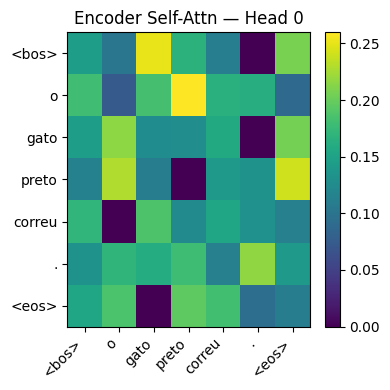

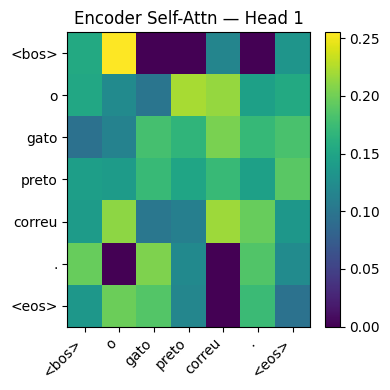

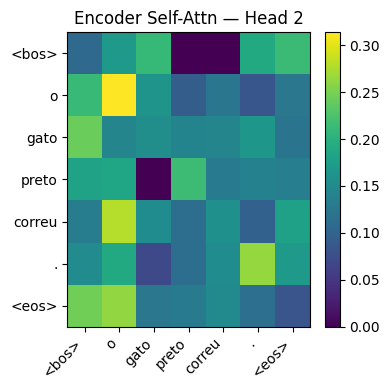

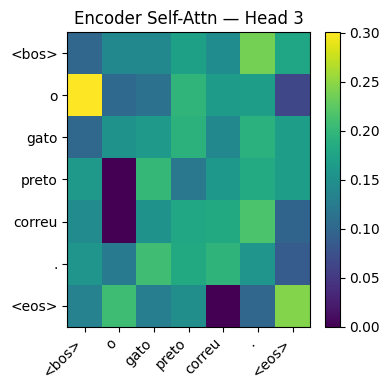

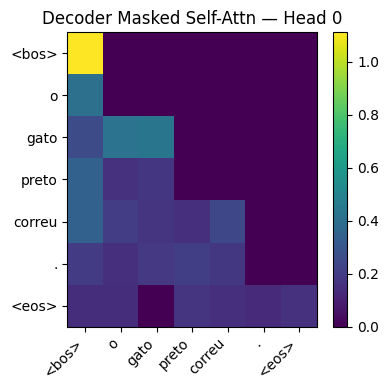

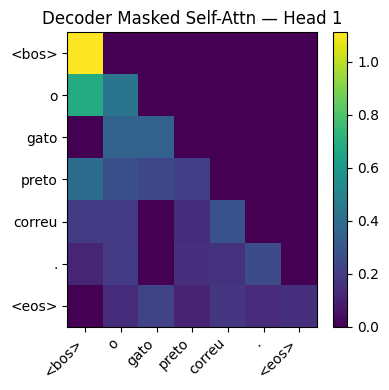

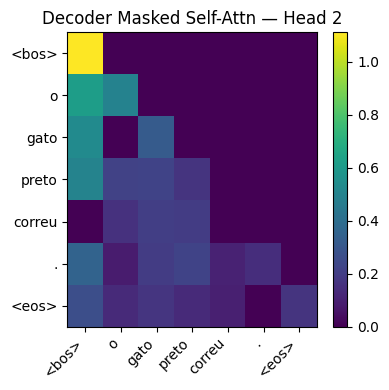

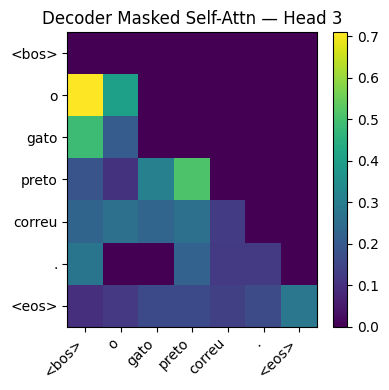

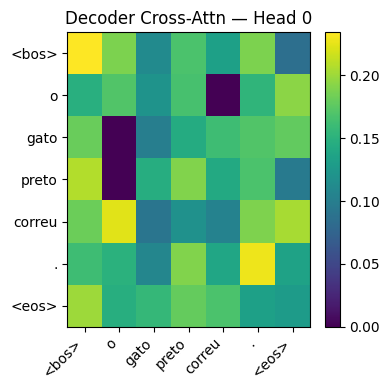

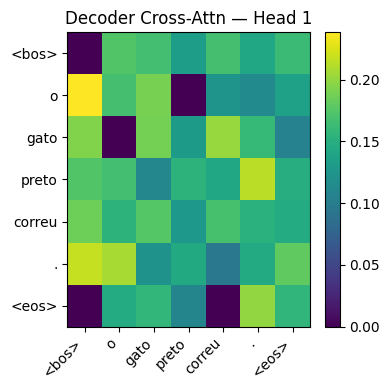

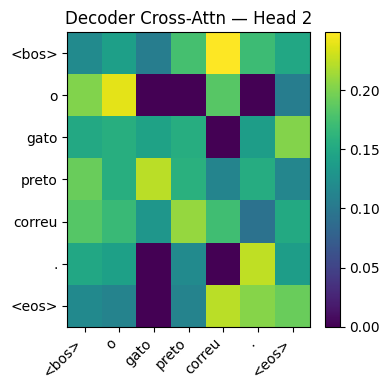

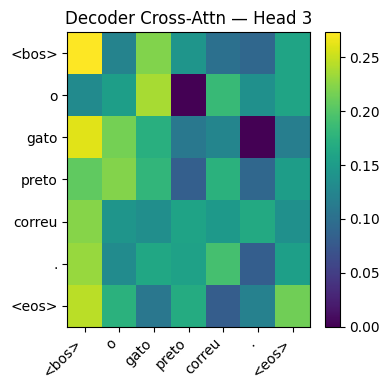

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heads(attn, x_labels, y_labels, title_prefix=""):
    """
    Visualiza mapas de atenção cabeça a cabeça.

    Parâmetros:
        attn: tensor de atenção (B, h, Tq, Tk)
               B = tamanho do batch (usaremos 1)
               h = número de cabeças
               Tq = comprimento da sequência de query
               Tk = comprimento da sequência de key
        x_labels: rótulos para o eixo x (tokens das keys)
        y_labels: rótulos para o eixo y (tokens das queries)
        title_prefix: string opcional para título (ex: "Encoder Self-Attn")
    """
    B, h, Tq, Tk = attn.shape
    assert B == 1, "Para fins didáticos, assumimos batch=1"

    for head in range(h):
        plt.figure(figsize=(4, 4))
        # Exibe o mapa de calor de atenção (valores ∈ [0,1])
        plt.imshow(attn[0, head].detach().cpu().numpy(), aspect="auto", cmap="viridis")

        # Rótulos dos eixos (tokens)
        plt.xticks(range(Tk), x_labels, rotation=45, ha="right")
        plt.yticks(range(Tq), y_labels)

        # Título e colorbar
        plt.title(f"{title_prefix} — Head {head}")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

# Recuperando atenções da última camada
enc_heads = attn_all["enc"][-1] if attn_all["enc"] else None  # (B,h,n,n)
dec_heads = attn_all["dec"][-1] if attn_all["dec"] else None  # dict {"self":(B,h,m,m), "cross":(B,h,m,n)}

# Rótulos de tokens (para exibir no eixo)
src_tokens = [ivocab[i.item()] for i in src[0]]
tgt_tokens = [ivocab[i.item()] for i in tgt[0]]

# -------------------- Visualizações --------------------
if enc_heads is not None:
    plot_heads(enc_heads, x_labels=src_tokens, y_labels=src_tokens, title_prefix="Encoder Self-Attn")

if dec_heads is not None:
    if "self" in dec_heads:
        plot_heads(dec_heads["self"], x_labels=tgt_tokens, y_labels=tgt_tokens, title_prefix="Decoder Masked Self-Attn")
    if "cross" in dec_heads:
        plot_heads(dec_heads["cross"], x_labels=src_tokens, y_labels=tgt_tokens, title_prefix="Decoder Cross-Attn")

## 8) Exercícios

1) **Altere `num_heads`** de 4 para 2 e 8; observe mudanças nos pesos por cabeça.  
2) **Troque `d_model`** (128 → 256) e **d_ff** (512 → 1024); discuta efeito na capacidade/parametrização.  
3) **Remova o PE** (retorne `x` sem `self.pe(x)`) e observe confusão de ordem (especialmente no decoder).  
4) **Desligue a máscara causal** (use máscara de todos 1s) e observe o vazamento de informação.  
5) **Imprima pesos de uma cabeça específica** para um par de tokens relacionado (ex.: substantivo↔adjetivo) e interprete.


> Referências no paper Attention is All You Need:  
> - Pilhas encoder/decoder com Add&Norm e d_model fixo: sec. **3.1**.   
> - Multi-Head Attention (projeções por cabeça, concatenação, h=8): sec. **3.2.2**.   
> - FFN position-wise (duas lineares + ReLU, d_ff=2048): sec. **3.3**.   
> - Positional Encoding senoidal: sec. **3.5**.   
> - Máscara causal no decoder: secs. **3.1** e **3.2.3**.  